# Outline of the Notebook

# Part I: Codes
## We import useful libraries and define functions for modeling inversion and regularization

# Part II: Applications (as seen in our article)
## Example 1: plasma wave equation 
## Example 2: acoustic wave equation with variable denisty 

# Part I

# Import libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import scipy as sp
import scipy.sparse as sps
from scipy import interpolate
from scipy.sparse.linalg import lsqr
from scipy import fft,ifft

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


# Functions for generating scattering data 

In [3]:
#The following wave solver is used in Example 1 (PLASMA WAVE EQUATION)
def SolveWE(q,f,T,L,h):
    """
    Solve plasma wave-equation 
    
        u_tt(t,x) = u_xx(t,x) - q(x) u(t,x) + f(t,x) on [0,T] x [0,L]
    
    Uses second-order FD scheme with absorbing boundary conditions
    
    input:
        q - scattering potential q(x) (callable)
        f - source function f(t,x) (callable)
        T,L - domain (floats)
        h - gridsize (float)
        
    output:
        t - temporal grid (1d array)
        x - spatial grid (1d array)
        u - solution (2d array)
    """
    
    Nt = int(round(T/h))
    t = np.linspace(0, Nt*h, Nt+1)   
    Nx = int(round(L/h))
    x = np.linspace(0, Nx*h, Nx+1) 
    
    u  = np.zeros((Nt+1,Nx+1)) 
    
    for n in range(1,Nt):
        u[n+1,0] = ( u[n,0] + (u[n,1] - u[n,0]) )
        u[n+1,1:-1] = -u[n-1,1:-1] + 2*u[n,1:-1] + (u[n,2:] - 2*u[n,1:-1] + u[n,0:-2]) + h**2*(-q(x[1:-1])*u[n,1:-1] + f(t[n],x[1:-1]))
        u[n+1,Nx] = ( u[n,Nx] + (u[n,Nx-1] - u[n,Nx]) )
        
    return t,x,u

# The following is used in Example 2 (ACOUSTIC WAVE EQUATION WITH VARIABLE DENSITY)
def SolveWE2(rho,f,T,L,dx):
    
    Le = 2.1*T
    
    nx = int(2*Le/dx - 1)
    dt = 0.8*h
    nt = int(T/dt)
    
    x = np.linspace(-Le+dx,Le-dx,nx)
    xm = np.linspace(-Le+dx/2,Le-dx/2,nx+1)
    t = np.linspace(0,T,nt)
    
    mu = rho(xm)
    A = sps.diags(1/rho(x),0)
    D = sps.diags([-np.ones(nx), np.ones(nx)],[-1,0],shape=(nx+1,nx))/dx
    M = sps.diags([mu],[0])
    I = sps.identity(nx)
    B = -D.T@M@D
    
    u = np.zeros((nt,nx))
    for k in range(2,nt-1):
        u[k+1] = (2*I + (dt**2)*A@B)@u[k] - u[k-1] + (dt**2)*A@f((k+1)*dt,x)
        
    a = nx//2
    b = np.where(x>L)[0][0]
    return t,x[a:b],u[:,a:b]

def H(x,f0):
    # smooth Heaviside
    return 0.5 + 0.5*sp.special.erf(np.pi*f0*x)

def delta(x,f0):
    # smooth approximation of \delta(x)
    return f0*np.sqrt(np.pi)*np.exp(-(np.pi*f0*x)**2)

def deltap(x,f0):
    # smooth approximation of \delta'(x)
    epsilon = 0.5/(np.pi*f0)**2
    return f0*np.sqrt(np.pi)*(-2*x*(np.pi*f0)**2)*np.exp(-(np.pi*f0*x)**2)

def getScatteringData2(rho,T,L,h,x0,t0,f0):
    """
    Generate scattering data by solving the wave-equation with source term
        
        f(t,x) = \delta(x-x0)\delta'(t-t0)
    
    input:
        rho,T,h - paramters for SolveWE2
        x0,t0,f0 - source parameters
        
    output:
        x - spatial grid (1d array)
        t - temporal grid (1d array)
        r - scattering data (1d array)
    """
    # source
    f = lambda t,x : delta(x-x0,f0)*deltap(t-t0,f0)
    
    # solve wave-equation
    t,x,u = SolveWE2(rho,f,T,L,h)
    t,x,u0 = SolveWE2(lambda x : 0*x + 1,f,T,L,h)
    
    # interpolate scattering data
    r = interpolate.interp1d(x,u - u0,axis=1)(x0)
    
    return x,t,r,u,u0

def getScatteringData(q,T,L,h,x0,t0,f0):
    """
    Generate scattering data by solving the wave-equation with source term
        
        f(t,x) = \delta(x-x0)\delta'(t-t0)
    
    input:
        q,T,h - paramters for SolveWE
        x0,t0,f0 - source parameters
        
    output:
        x - spatial grid (1d array)
        t - temporal grid (1d array)
        r - scattering data (1d array)
    """
    # source
    f = lambda t,x : delta(x-x0,f0)*deltap(t-t0,f0)
    
    # solve wave-equation
    t,x,u = SolveWE(q,f,T,L,h)
    t,x,u0 = SolveWE(lambda x : 0*x,f,T,L,h)
    
    # interpolate scattering data
    r = interpolate.interp1d(x,u - u0,axis=1)(x0)
    
    return x,t,r

# Tikhonov/Least squares function definition

In [4]:
def Solve_GLM_LS(r,t,alpha=1e-16):
    """
    Solve the GLM equation: 
        
        r(x + y) + \int_0^T B(x,z)r(x + y + z)dz + B(x,y) = 0
    
    for B(x,z) by posing it as a regularised least-squares problem
    
        min_b \|A_x b + r_x\|_2^2 + \alpha \|L b\|_2^2,
        
    with L the second derivative operator.
    
    input:
        r - scattering data (1d array)
        t - temporal grid at which r is given (1d array)
        alpha - regularization parameter (float), default=1e-16
        method - {'tsvd','lsqr'}, default='lsqr'
    
    output:
        B - solution (2d array)
        t - temporal grid at which B is defined (1d array)
        phi - value of objective
    """
    # grid
    nt = len(t)
    dt = t[2]-t[1]
    mt = int(nt/3)
    
    # Regularisation operator
    L = sps.spdiags(np.outer(np.array([1,-2,1]),np.ones(mt)),np.array([-1,0,1]),mt,mt).toarray()
    
    # initialize
    B = np.zeros((mt,mt))
    phi = 0
    
    # solve for every column
    for j in range(mt):
        # generate operator (Hankel matrix)
        I = np.identity(mt)
        R = la.hankel(r[j:j+mt],r[j+mt-1:j+2*mt-1])
        A = I + dt*R
        B[:,j] = lsqr(np.concatenate((A,np.sqrt(alpha)*L)),np.concatenate((-r[j:j+mt],np.zeros(mt))))[0]
        phi += np.linalg.norm(B[:,j] + dt*R@B[:,j] + r[j:j+mt])**2 + alpha*np.linalg.norm(L@B[:,j])**2
    return B,t[:mt],phi

# Total least squares function

In [5]:
def Solve_GLM_TLS(r,t,alpha=1e-16,beta=1e-3,maxit=(10,10)):
    """
    Solve the GLM equation: 
        
        (r + e)(x + y) + \int_0^T B(x,z)(r + e)(x + y + z)dz + B(x,y) = 0.
    
    for e and B in a Total Least-Squares sense using altermating minimisation.
    
    input:
        r - scattering data (1d array)
        t - temporal grid at which r is given (1d array)
        alpha - regularization parameter for \|B\|^2 (float), default=(1e-16)
        beta - regularization parameter for \|e\|^2 (float), default=(1e-3)
        maxit - maximum (inner,outer) iterations (int,int), default=(10,10)
    
    output:
        B - estimated kernel (2d array)
        e - estimated error
        t - temporal grid at which B is defined (1d array)
        hist - objective at each iteration (1d array)
    """
    
    # grid
    nt = len(t)
    dt = t[2]-t[1]
    mt = int(nt/3)
    
    # initialize
    B = np.zeros((mt,mt))
    e = np.zeros(nt)
    hist = np.zeros(maxit[1])
    
    # Regularisation operator
    L = sps.spdiags(np.outer(np.array([1,-2,1]),np.ones(mt)),np.array([-1,0,1]),mt,mt).toarray()
    
    # main loop
    for it in range(maxit[1]):
        # estimate kernel
        B,ts,phi= Solve_GLM_LS(r + e,t,alpha)
        
        # estimate error
        
        ## first, setup system of m^2 x n equations for e
        A = np.zeros((mt**2,nt))
        b = np.zeros(mt**2)
        k = 0
        for i in range(mt):
            for j in range(mt):
                A[k,i+j] = 1
                A[k,i+j:i+j+mt] += dt*B[:,i]
                b[k] = -(r[i + j] + dt*B[:,i].dot(r[i+j:i+j+mt]) + B[j,i])             
                k += 1
        ## now solve it
        e = lsqr(A,b,damp=np.sqrt(beta),iter_lim=maxit[0])[0]
        
        ## objective
        hist[it] = phi + beta*np.linalg.norm(e)**2
    return B,e,t[:mt],hist

In [6]:
def reconstruct(B,ts,t0,x0):
    """
    Reconstruct scattering potential from Kernel
    """
    ns = len(ts)-2
    xs = ts[1:-1]/2-(t0/2-x0)
    h = (xs[1] - xs[0])
    
    q_hat = 2*(B[0,2:] - B[0,:-2])/(h)
    return q_hat, xs

# Part II

# Example 1

# Generate scattering data

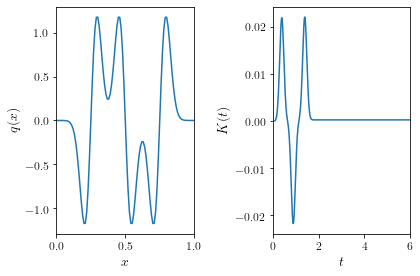

In [7]:
# domain and grid: t \in [0,T], x \in [0,L]
T = 6
L = 1
h = 0.01
#h=0.02
# parameters: t0 - time offset, x0 - spatial offset, f0 - central frequency
t0 = .1
x0 = .1
f0 = 10

# velocity and density
c = lambda x : 1 + 0*x
rho = lambda x : 1 - 1e-2*H(x-.25,f0/2) + 1e-2*H(x-.5,f0/2) - 1e-2*H(x-.75,f0/2)

# scattering potential
q = lambda x : ((rho(x+h) - 2*rho(x) + rho(x-h))/h**2)/np.sqrt(rho(x))

# get scattering data
x,t,r = getScatteringData(q,T,L,h,x0,t0,2*f0)

# plot
fig,ax = plt.subplots(1,2)

ax[0].plot(x,q(x))
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$q(x)$')
ax[0].set_xlim([0,L])

ax[1].plot(t,r)
ax[1].set_xlim([0,T])
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$K(t)$')

fig.tight_layout()
#plt.savefig("q(x),r(t)-example1.pdf",dpi=600)

# Solve noise-free problem

In [8]:
%%time
B_hat,ts,phi= Solve_GLM_LS(r,t,alpha=1e-16)
q_hat, xs = reconstruct(B_hat,ts,t0,x0)

CPU times: user 750 ms, sys: 42.2 ms, total: 792 ms
Wall time: 204 ms


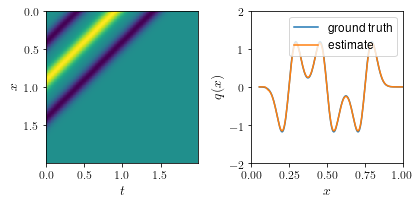

In [9]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(B_hat,extent=[0,ts[-1],ts[-1],0])
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')
#ax[0].set_title('GLM kernel')

ax[1].plot(xs,q(xs),label='ground truth')
ax[1].plot(xs,q_hat,label='estimate')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$q(x)$')
ax[1].set_xlim([0,L])
ax[1].set_ylim([-2,2])
ax[1].set_aspect(.25)
ax[1].legend(loc='upper right')
#ax[1].set_title('potentials')


fig.tight_layout()
#plt.savefig("Btrue,q_true,q_recovered.pdf",dpi=600)

# We add random noise and we solve the problem again

In [10]:
sigma = 1e-3
r_delta = r + sigma*np.random.randn(len(r))
B_hat,ts,phi= Solve_GLM_LS(r_delta,t,alpha=1e-2)
q_hat, xs = reconstruct(B_hat,ts,t0,x0)

Text(0.5, 1.0, 'noisy scattering data')

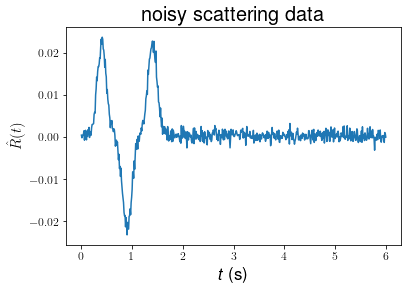

In [11]:
plt.plot(t,r_delta)
plt.xlabel(r'\textit{t} (s)',fontsize=17)
plt.ylabel('$\hat{R}(t)$',fontsize=15)
#plt.xlim(0,2)
plt.title('noisy scattering data',fontsize=20)
#plt.savefig("n-scattering-data.pdf",dpi=600)

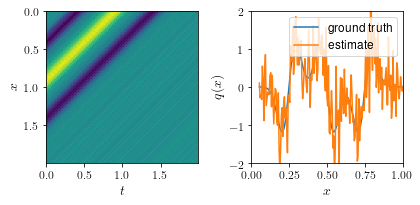

In [12]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(B_hat,extent=[0,ts[-1],ts[-1],0])
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')

ax[1].plot(xs,q(xs),label='ground truth')
ax[1].plot(xs,q_hat,label='estimate')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$q(x)$')
ax[1].set_xlim([0,L])
ax[1].set_ylim([-2,2])
ax[1].set_aspect(.25)
ax[1].legend(loc='upper right')
#ax[1].set_title('potentials')

fig.tight_layout()
#plt.savefig("Bnoisy,q_true,q_noisy.pdf",dpi=600)

# Estimation of the Tikhonov parameter (the best possible actually)

In [19]:
%%time
# effect of error and Tikhonov on estimated kernel
#sigma = np.logspace(-9,-3,5)
sigma = np.logspace(-3,-2,1)
#alpha = np.logspace(-10,1,12)
alpha=np.linspace(0,2,161)
error = np.zeros((len(sigma),len(alpha)))

# reconstruction without noise
B0,ts,phi= Solve_GLM_LS(r,t,alpha=1e-16)

for k in range(len(sigma)):
    r_delta = r + sigma[k]*np.random.randn(len(r))
    for l in range(len(alpha)):
        Bk,ts,phi= Solve_GLM_LS(r_delta,t,alpha=alpha[l])
        error[k,l] = np.linalg.norm(Bk - B0,ord='fro')/np.linalg.norm(B0)


CPU times: user 7min 29s, sys: 9.9 s, total: 7min 39s
Wall time: 2min


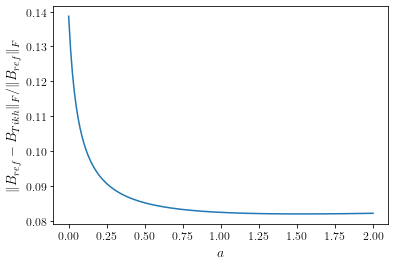

In [23]:
plt.plot(alpha,error[0,:])
plt.xlabel('$a$')
plt.ylabel('$\|B_{ref} - B_{Tikh}\|_{F}/\| B_{ref}\|_{F}$')
plt.savefig("ls.pdf",dpi=600)

In [24]:
alpha[np.argmin(error[0,:])]

1.5250000000000001

# Estimate the best possible TLS parameters

In [16]:
%%time
# effect of error and regularisation on estimated kernel
sigma = 1e-3

alpha=np.logspace(-5,0,5)
beta=np.logspace(-5,0,5)
error = np.zeros((len(alpha),len(beta)))

# reconstruction without noise
b0,ts,phi = Solve_GLM_LS(r,t,alpha=1e-16)

for k in range(len(alpha)):
    r_delta = r + sigma*np.random.randn(len(r))
    for l in range(len(beta)):
        bk,ts,ek,res = Solve_GLM_TLS(r_delta,t,alpha=alpha[k],beta=beta[l],maxit=(10,20))
        error[k,l] = np.linalg.norm(bk - b0)/np.linalg.norm(b0)

CPU times: user 24min 24s, sys: 1min 7s, total: 25min 32s
Wall time: 7min 43s


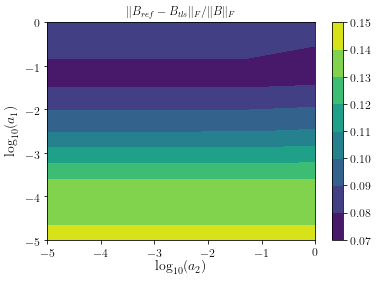

In [17]:
fig,ax = plt.subplots(1,1)

cs = ax.contourf(np.log10(beta),np.log10(alpha),error)
#cs = ax.contourf(beta,alpha,error)
ax.set_title('$\|B_{ref} - B_{tls}\|_F/\|B\|_F$')
ax.set_ylabel(r'$\log_{10}(a_1)$')
ax.set_xlabel(r'$\log_{10}(a_2)$')
fig.colorbar(cs)
#plt.savefig("relative error.pdf",dpi=600)#3

In [27]:
%%time
# parameters
sigma = 1e-3
alpha = 1e-1
beta = 1e-5
alphaLS=1.525

# noisy data
r_delta = r + sigma*np.random.randn(len(r))

# reference solution
B0,ts,phi= Solve_GLM_LS(r,t,alpha=alpha)

# LS solution
B_ls,ts,phi= Solve_GLM_LS(r_delta,t,alpha=alpha)

# TLS
B_tls,e_tls,ts,hist = Solve_GLM_TLS(r_delta,t,alpha=alpha,beta=beta,maxit=(10,20))

CPU times: user 1min 4s, sys: 2.86 s, total: 1min 7s
Wall time: 20.3 s


# Comparison of the kernels (TLS,Tikhonov, kernel from noise-free scattering data) at $t=0$

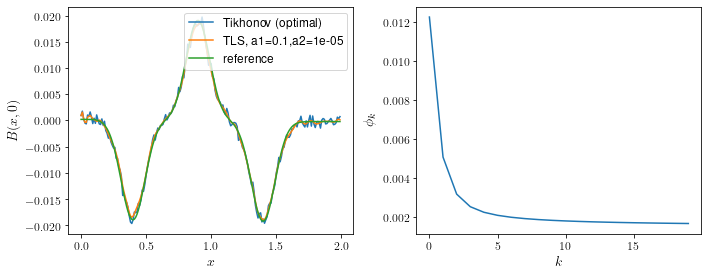

In [28]:
fig,ax = plt.subplots(1,2)

ax[0].plot(ts,B_ls[0,:],label='Tikhonov (optimal) ')
ax[0].plot(ts,B_tls[0,:],label='TLS, a1='+str(alpha)+',a2='+str(beta))
ax[0].plot(ts,B0[0,:],label='reference')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$B(x,0)$')
ax[0].legend()
#ax[0].set_title('kernel slices')


ax[1].plot(hist)
ax[1].set_xlabel('$k$')
ax[1].set_ylabel('$\phi_k$')
#ax[1].set_title('convergence to critical point')
fig.set_figwidth(10)
fig.tight_layout()
#plt.savefig("B(x,0)_true,LS,TLS,phi.pdf",dpi=600)

# Example 2 (same steps as in Example 1)

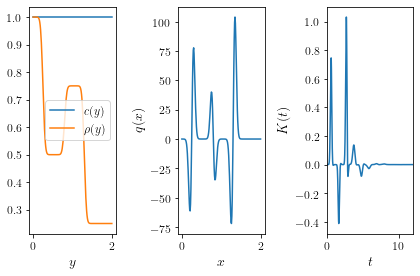

In [8]:
# domain and grid: t \in [0,T], x \in [0,L]
T = 12
L = 2
h = 0.01

# parameters: t0 - time offset, x0 - spatial offset, f0 - central frequency
t0 = .1
x0 = 0
f0 = 10

# velocity and density
c = lambda x : 1 + 0*x
rho = lambda x : 1 - .5*H(x-.25,f0/2) + .25*H(x-.8,f0/2) - .5*H(x-1.3,f0/2)

# scattering potential
q = lambda x : ((rho(x+h) - 2*rho(x) + rho(x-h))/h**2)/np.sqrt(rho(x))

# get scattering data
x,t,r,u,u0 = getScatteringData2(rho,T,L,h,x0,t0,2*f0)

# plot
fig,ax = plt.subplots(1,3)

ax[0].plot(x,c(x),label='$c(y)$')
ax[0].plot(x,rho(x),label=r'$\rho(y)$')
ax[0].set_xlabel('$y$')
#ax[0].set_title('density,velocity',fontsize=15)
ax[0].legend(loc='lower left')
ax[0].legend()

ax[1].plot(x,q(x))
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$q(x)$')
#ax[1].set_title('potential (travel-time)',fontsize=15)

ax[2].plot(t,r)
ax[2].set_xlim([0,T])
ax[2].set_xlabel('$t$')
ax[2].set_ylabel('$K(t)$')
#ax[2].set_title('scattering data',fontsize=15)

fig.tight_layout()
#plt.savefig("Example2-c-q-K.pdf",dpi=600)

In [9]:
%%time
B_hat,ts,phi = Solve_GLM_LS(r,t,alpha=1e-16)
q_hat, xs = reconstruct(B_hat,ts,t0,x0)

CPU times: user 7.28 s, sys: 475 ms, total: 7.76 s
Wall time: 1.95 s


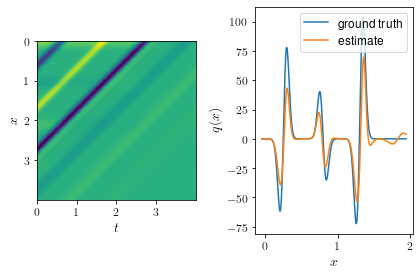

In [10]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(B_hat,extent=[0,ts[-1],ts[-1],0])
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')
#ax[0].set_title('GLM kernel')

ax[1].plot(xs,q(xs),label='ground truth')
ax[1].plot(xs,q_hat,label='estimate')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$q(x)$')
#ax[1].set_xlim([0,L])
#ax[1].set_ylim([-2,2])
#ax[1].set_aspect(.25)
ax[1].legend(loc='upper right')
#ax[1].set_title('potentials')

fig.tight_layout()
#plt.savefig("Example2-B-q-reconstructed",dpi=600)

In [11]:
sigma = 1e-2
r_delta = r + sigma*np.random.randn(len(r))
B_hat,ts,phi= Solve_GLM_LS(r_delta,t,alpha=1e-2)
q_hat, xs = reconstruct(B_hat,ts,t0,x0)

Text(0, 0.5, 'K(t)')

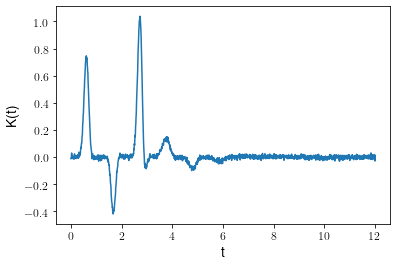

In [12]:
#Noisy scattering data
plt.plot(t,r_delta)
plt.xlabel("t")
plt.ylabel("K(t)")
#plt.savefig("noisy-scattering-data.pdf",dpi=600)

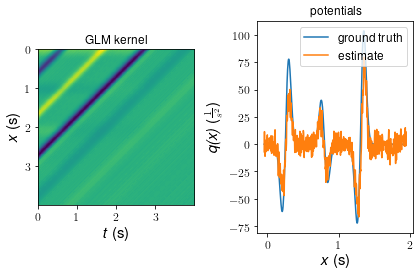

In [34]:
# GLM Kernel and potential from noisy scattering data, no regularization
fig,ax = plt.subplots(1,2)

ax[0].imshow(B_hat,extent=[0,ts[-1],ts[-1],0])
ax[0].set_xlabel(r'\textit{t} (s)',fontsize=15)
ax[0].set_ylabel(r'\textit{x} (s)',fontsize=15)
ax[0].set_title('GLM kernel')

ax[1].plot(xs,q(xs),label='ground truth')
ax[1].plot(xs,q_hat,label='estimate')
ax[1].set_xlabel(r'\textit{x} (s)',fontsize=15)
ax[1].set_ylabel(r'\textit{q(x)} ($\frac{1}{s^2}$)',fontsize=15)
#ax[1].set_xlim([0,L])
#ax[1].set_ylim([-2,2])
#ax[1].set_aspect(.25)
ax[1].legend(loc='upper right')
ax[1].set_title('potentials')

fig.tight_layout()
#plt.savefig("Bnoisy,q_true,q_noisy.pdf",dpi=600)

In [19]:
%%time
# effect of error and Tikhonov on estimated kernel
sigma = np.logspace(-2,-1,1)
alpha = np.linspace(0,1,11)
error = np.zeros((len(sigma),len(alpha)))

# reconstruction without noise
B0,ts,phi = Solve_GLM_LS(r,t,alpha=1e-16)

for k in range(len(sigma)):
    r_delta = r + sigma[k]*np.random.randn(len(r))
    for l in range(len(alpha)):
        Bk,ts,phi= Solve_GLM_LS(r_delta,t,alpha=alpha[l])
        error[k,l] = np.linalg.norm(Bk - B0,ord='fro')

CPU times: user 2min 34s, sys: 7.25 s, total: 2min 41s
Wall time: 41.5 s


0.4

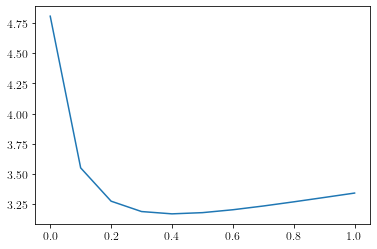

In [20]:
plt.plot(alpha,error[0,:])
alpha[np.argmin(error[0,:])]

In [16]:
%%time
# effect of error and regularisation on estimated kernel
sigma = 1e-2

alpha = np.logspace(-5,0,5)
beta  = np.logspace(-5,0,5)
error = np.zeros((len(alpha),len(beta)))

# reconstruction without noise
b0,ts,phi = Solve_GLM_LS(r,t,alpha=1e-16)

for k in range(len(alpha)):
    r_delta = r + sigma*np.random.randn(len(r))
    for l in range(len(beta)):
        bk,ts,ek,res = Solve_GLM_TLS(r_delta,t,alpha=alpha[k],beta=beta[l],maxit=(10,20))
        error[k,l] = np.linalg.norm(bk - b0)/np.linalg.norm(b0)

CPU times: user 3h 32min 31s, sys: 14min 15s, total: 3h 46min 47s
Wall time: 1h 14min 57s


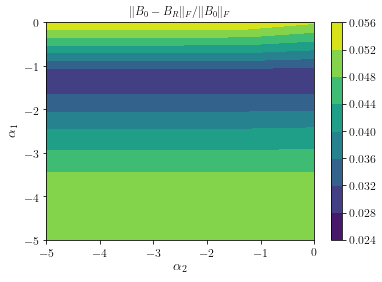

In [17]:
fig,ax = plt.subplots(1,1)

cs = ax.contourf(np.log10(beta),np.log10(alpha),error)
ax.set_title('$\|B_0 - B_R\|_{F}/\|B_0\|_F$')
ax.set_ylabel(r'$\alpha_1$')
ax.set_xlabel(r'$\alpha_2$')
fig.colorbar(cs)
#plt.savefig("relative error.pdf",dpi=600)

In [28]:
%%time
# parameters
sigma = 1e-2
alpha = 1e-1
beta = 1e-1
alphaLS=0

# noisy data
r_delta = r + sigma*np.random.randn(len(r))

# reference solution
B0,ts,phi= Solve_GLM_LS(r,t,alpha=alphaLS)

# LS solution
B_ls,ts,phi= Solve_GLM_LS(r_delta,t,alpha=alpha)

# TLS
B_tls,e_tls,ts,hist = Solve_GLM_TLS(r_delta,t,alpha=alpha,beta=beta,maxit=(10,20))

CPU times: user 8min 47s, sys: 35.4 s, total: 9min 23s
Wall time: 3min 1s


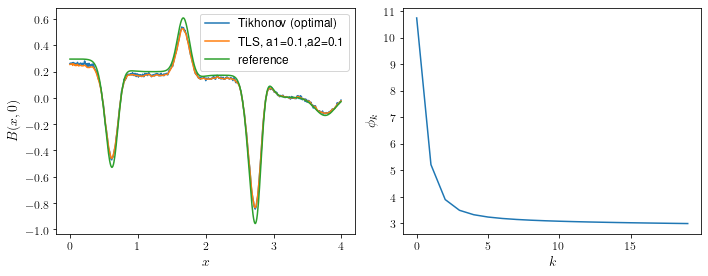

In [29]:
fig,ax = plt.subplots(1,2)

ax[0].plot(ts,B_ls[0,:],label='Tikhonov (optimal) ')
ax[0].plot(ts,B_tls[0,:],label='TLS, a1='+str(alpha)+',a2='+str(beta))
ax[0].plot(ts,B0[0,:],label='reference')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$B(x,0)$')
ax[0].legend()
#ax[0].set_title('kernel slices')


ax[1].plot(hist)
ax[1].set_xlabel('$k$')
ax[1].set_ylabel('$\phi_k$')
#ax[1].set_title('convergence to critical point')
fig.set_figwidth(10)
fig.tight_layout()
#plt.savefig("B(x,0)_true,LS,TLS,phi-2.pdf",dpi=600)